# 2020 Election - The Debunk went down to Georgia...

This notebook is a quick response to a video from alleged Data Scientists claiming evidence of voter fraud in Georgia in the 2020 elections. Their beginning assertions raised some immediate red flags, which were easily illustrated using rudimentary plotting and aggregating with [data from previous presidential elections in 2004, 2008, and 2012 at the precinct level](https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/21919#).

**Update - also included is [data from the 2016 presidential election](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FLYWX3D).

This will be entirely useless and uninteresting outside of the context of debunking that specific claim but please forward it as needed if you need something quick to address that particular spread of misinformation. Feel free to expand upon it as needed.

Datasets accessed from:<br>
Ansolabehere, Stephen; Palmer, Maxwell; Lee, Amanda, 2014, "Precinct-Level Election Data", https://doi.org/10.7910/DVN/YN4TLR, Harvard Dataverse, V1, UNF:5:5C9UfGjdLy2ONVPtgr45qA== [fileUNF]

MIT Election Data and Science Lab, 2018, "U.S. President Precinct-Level Returns 2016", https://doi.org/10.7910/DVN/LYWX3D, Harvard Dataverse, V11, UNF:6:hQyVqHW+vTFnAW2jYIOy/Q== [fileUNF]

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

First the presidential election datasets from 2004, 2008, and 2012 are loaded

In [2]:
#These names are for reducing the dataframe to only information about the presidential election.
relevant_columns = ["state", "year", "county", "precinct", "USP_tv", "USP_rv", "USP_dv"]

# Imports the original dataframes for each year and simplifies the column choices/names
df2004 = pd.read_csv("GA_2004.tab", delimiter="\t").rename(columns={"g2004_USP_tv":"USP_tv", "g2004_USP_rv":"USP_rv", "g2004_USP_dv":"USP_dv"})[relevant_columns]
df2008 = pd.read_csv("GA_2008.tab", delimiter="\t").rename(columns={"g2008_USP_tv":"USP_tv", "g2008_USP_rv":"USP_rv", "g2008_USP_dv":"USP_dv"})[relevant_columns]
df2012 = pd.read_csv("GA_2012.tab", delimiter="\t").rename(columns={"g2012_USP_tv":"USP_tv", "g2012_USP_rv":"USP_rv", "g2012_USP_dv":"USP_dv"})[relevant_columns]


# The data for 2016 comes from a bigger dataset containing the entire nation's election results and additional columns. The following code standardizes it to match
# the format of the other years
df2016 = pd.read_csv("2016-precinct-president.tab", delimiter="\t")
# Including only Georgia and the columns that contain datapoints within it
df2016 = df2016[df2016["state"]=="Georgia"].dropna(axis=1, how="all")
# This is a check on the candidate column to check for missing values to ensure the correct columns are chosen in restructuring the dataframe format.
print("There are ", df2016["candidate"].isna().sum(), " missing columns for 'candidate'")
# I chose not to exclude the provisional ballots in these counts. There is no reason to believe that these counts included the ones that may have been
# exculded and they make up less than .2% of the total vote
print(f'{df2016[df2016["mode"]=="provisional"]["votes"].sum()/df2016["votes"].sum()*100:.2f}% Provisional ballots - Included')
# Reduces the columns to what is needed to match the structure of the other datasets.
df2016 = df2016[["state", "year", "county_name", "precinct", "candidate", "votes"]].rename(columns={"county_name":"county"})
# Aggregates the totals within voting methods and pivots the candidates to a column instead of a row.
df2016 = df2016.groupby(["state", "year", "county", "precinct", "candidate"]).sum().unstack("candidate")["votes"]
# Calculates the total votes across all the candidates into a column matching the format of the other dataset
df2016["USP_tv"] = df2016.sum(axis=1)
# Resets the index back while taking only the total vote counts and those for Democrats and Republicans.
df2016 = df2016[["USP_tv", "Donald Trump", "Hillary Clinton"]].rename(columns={"Donald Trump":"USP_rv", "Hillary Clinton":"USP_dv"}).reset_index()
##There are a few write-in votes that are unattached to any precinct. They make up .5% of the vote and will be dropped from the totals.
print(f'{df2016[df2016["precinct"]=="Write-ins"]["USP_tv"].sum()/df2016["USP_tv"].sum()*100:.2f}% Write in candidates - Excluded')
df2016 = df2016[df2016["precinct"]!="Write-ins"]
# Minor cleanup to match format of other datasets.
df2016.columns.name = None

# In 2012 Fulton County is named Fulton and is changed to match other years.
df2012["county"] = np.where(df2012["county"]=="Fulton", "Fulton County", df2012["county"])

/opt/conda/envs/main/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (13,17,19,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are  0  missing columns for 'candidate'
0.19% Provisional ballots - Included
0.54% Write in candidates - Excluded


In [3]:
# Combines the data from the three years into a single dataframe
df = pd.concat([df2004, df2008, df2012, df2016], ignore_index=True)

## Unnuanced claim - "Receiving 75% or more votes for a candidate in a precinct is 'abnormal'"

% democrat = democratice votes/ total votes * 100<br>
% republican = republican votes/ total votes * 100

In [4]:
df["democratic_percentages"] = df["USP_dv"]/df["USP_tv"] * 100
df["republican_percentages"] = df["USP_rv"]/df["USP_tv"] * 100

In response to the assertion that "receiving 75% or more votes for a candidate in a precinct is 'abnormal' a quick preview of the data shows that how easily this line of thinking falls apart. Immediately in the very the first few precincts in Appling County in 2004 there appears an overwhelming amount of republican votes. Voter demographics and values can vary widely depending on geographic location.

## Actual reality - It depends on the precinct

In [5]:
df.head(10)

,state,year,county,precinct,USP_tv,USP_rv,USP_dv,democratic_percentages,republican_percentages
0,GA,2004,Appling County,1-A,141.0,112.0,28.0,19.858156,79.432624
1,GA,2004,Appling County,1-A1,170.0,146.0,23.0,13.529412,85.882353
2,GA,2004,Appling County,1-B,531.0,388.0,140.0,26.365348,73.069680
3,GA,2004,Appling County,1-C,377.0,300.0,75.0,19.893899,79.575597
4,GA,2004,Appling County,1-D,64.0,47.0,17.0,26.562500,73.437500
5,GA,2004,Appling County,2,782.0,305.0,471.0,60.230179,39.002558
6,GA,2004,Appling County,3-A,158.0,142.0,16.0,10.126582,89.873418
7,GA,2004,Appling County,3-B,193.0,101.0,90.0,46.632124,52.331606
8,GA,2004,Appling County,3-C,625.0,441.0,179.0,28.640000,70.560000
9,GA,2004,Appling County,4-A,216.0,186.0,29.0,13.425926,86.111111


To gain more insight about Fulton County, we can plot a density plot for each year that will guage the percentages of demographic votes in each precinct.

In [6]:
# Reducing the data to Fulton County
fulton = df[df["county"]=="Fulton County"].copy()
fulton2004 = fulton[fulton["year"]==2004]
fulton2008 = fulton[fulton["year"]==2008]
fulton2012 = fulton[fulton["year"]==2012]
fulton2016 = fulton[fulton["year"]==2016]

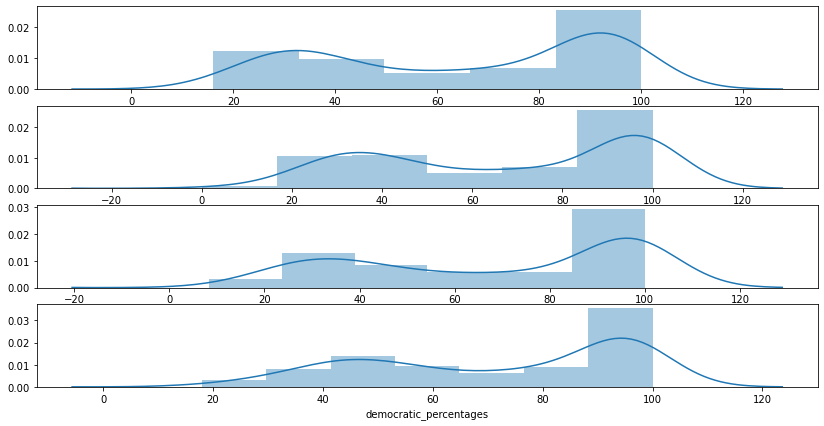

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1,figsize=(14,7))
sns.distplot(fulton2004["democratic_percentages"], ax=ax1)
sns.distplot(fulton2008["democratic_percentages"], ax=ax2)
sns.distplot(fulton2012["democratic_percentages"], ax=ax3)
sns.distplot(fulton2016["democratic_percentages"], ax=ax4)
plt.show()

It is already apparent that a heavy Democratic skew is normal for this county (as most metropolitan areas tend to have), but it would benefit to match the groups set up in the video to unveil the true lack of statistical knowledge in the contested assertions.

In [8]:
def bin_percentages(percentage):
    """This maps the percentages of Democratic votes several defined groups for comparison."""
    
    if percentage >= 96:
        group = "96-100%"
    elif percentage >= 95:
        group = "95%"
    elif percentage >= 94:
        group = "94%"
    # Really should be 90 - 94%, but mimicking the faulty naming conventions of the presentation.
    elif percentage >= 90:
         group = "90-93%"
    else:
        group = "Under 90%"
        
    return group

def precincts_over_percent(percentage, percent_value=90):
    """returns a one when a precinct percentage matches a specific threshold, and a zero if it does not."""
    if percentage >= percent_value:
        return 1
    else:
        return 0

In [9]:
fulton["dem_percent bins"] = fulton["democratic_percentages"].map(bin_percentages)
fulton["over_90%"] = fulton["democratic_percentages"].map(precincts_over_percent)

In [10]:
# Counts the number of precincts that fall into each category.
precinct_count = fulton.groupby(["year", "dem_percent bins"]).count()[["precinct"]].rename(columns={"precinct":"precinct_count"}).reset_index()

# Organization to the order of the categories.
bin_order = ["Under 90%", "90-93%", "94%", "95%", "96-100%"]
precinct_count = precinct_count.set_index("dem_percent bins").loc[bin_order].reset_index()
precinct_count = precinct_count.sort_values("year", kind= "stable")

# Creates totals to aggregate percentages.
total_precincts = precinct_count.groupby("year")["precinct_count"].sum().rename("total_precincts")
precinct_count = precinct_count.join(total_precincts, on="year", how="left")
precinct_count["precincts_over_90%"] = precinct_count["total_precincts"]

# Creates a percentage from the counts and the totals
precinct_count["percentage"] = precinct_count["precinct_count"]/precinct_count["total_precincts"]*100
precinct_count

,dem_percent bins,year,precinct_count,total_precincts,precincts_over_90%,percentage
0,Under 90%,2004,223,336,336,66.369048
4,90-93%,2004,44,336,336,13.095238
8,94%,2004,30,336,336,8.928571
12,95%,2004,25,336,336,7.440476
16,96-100%,2004,14,336,336,4.166667
1,Under 90%,2008,206,339,339,60.766962
5,90-93%,2008,18,339,339,5.309735
9,94%,2008,5,339,339,1.474926
13,95%,2008,11,339,339,3.244838
17,96-100%,2008,99,339,339,29.203540


In [11]:
precincts_over_90 = fulton.groupby(["year", "over_90%"])[["precinct", "USP_dv"]].agg(["count", "sum"]).rename(columns={"precinct":"precinct_count"}).reset_index()

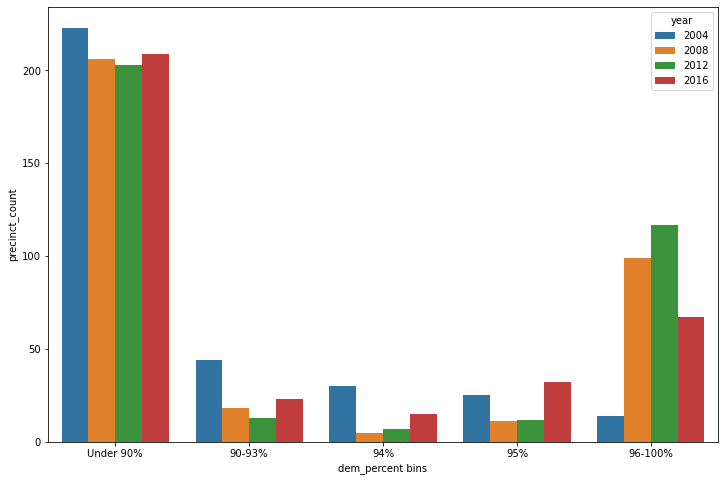

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(x="dem_percent bins", y="precinct_count", hue="year", data=precinct_count)
plt.show()

When viewed in terms of percentages, it appears that the Fulton precinct may be getting bluer, but realistically there are too many other variables (different candidates, public approval), to be able to even think about saying with any degree of certainty using only this dataset.

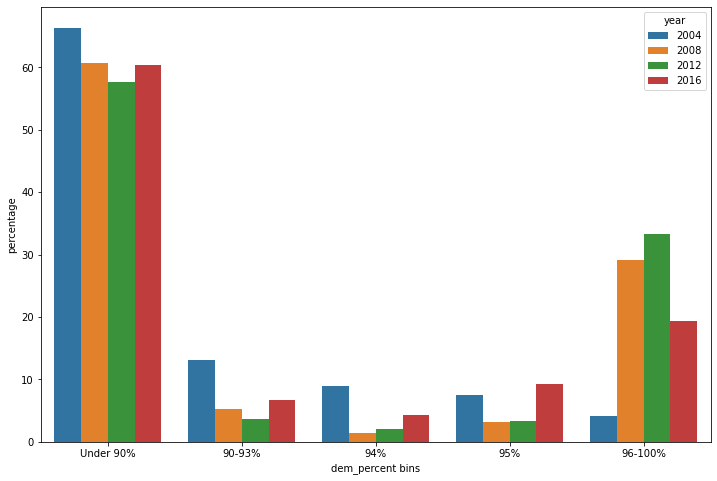

In [13]:
plt.figure(figsize=(12,8))
sns.barplot(x="dem_percent bins", y="percentage", hue="year", data=precinct_count)
plt.show()

Finally the the counts above 90% are aggregated to compare with the results of 2020 to and show the absurdity of claiming that 150,000 votes across 150 precincts with over 90% votes for the democratic party to be coherent "evidence" of voter fraud. 2020 was an extremely polarizing election that brought out record turnout of voters. With just a few very basic aggregations, the accusation that the Fulton precinct was highly unlikely to those results legitimately, appears to be no more than sloppy conjecture.

In [14]:
precincts_over_90 = fulton[fulton["democratic_percentages"]>=90]
precincts_over_90.groupby("year")[["precinct", "USP_dv"]].agg({"precinct":"count", "USP_dv":"sum"}).rename(columns={"precinct":"precincts_over_90%", "USP_dv":"democratic_votes"})

,precincts_over_90%,democratic_votes
year,,
2004,113,72837.0
2008,133,59731.0
2012,149,133489.0
2016,137,124983.0


The later assertions in that video will be unaddressed. Practically speaking, the growing tendency to overwhelm people's patience for public discourse with dubious "facts", is a dangerous trend. Quality matters is essential and trying to fill that void by overcompensating with quantity instead makes one's tactics no better than a devout adherent to the Flat Earth movement.

While saying nothing allows the pursuit of ignorance to continue unhindered, saying too much makes it impossible to practically get anything done. I am not familiar enough with the voting tabulation process to want to take on the project of the later claims made in the presentation. However, what has been said should be sufficient as it is very telling of the "statistical rigor" when the very first claim made is a distortion of reality. That may be all that is necessary in making a snap judgment for all practical purposes, but if anyone else has access to more data on hand and has the time to offer in investigating/debunking the rest of it I would welcome collaborators.